# Conic unbalanced optimal transport. 
This entropic regularization is yet another entropic regularization of unbalanced optimal transport (UOT). It differs from standard entropic unbalanced optimal transport. The main difference being that this regularization is the corresponding (static) Schrödinger bridge on the cone of position and mass not under marginal constraints but rather under moment constraints.

Standard entropic regularization of unbalanced optimal transport consists in adding the Kullback-Leibler divergence on the primal problem. Given positive Radon measures $\rho_1$ and $\rho_2$, the convex optimization problem of standard entropic UOT reads
\begin{multline*}
WF^2(\rho_1,\rho_2) = \inf_{\gamma} KL(p^1_*\gamma,\rho_1) + KL(p^2_* \gamma,\rho_2) - \int_{M^2} \gamma(x,y) \log(\cos^2(d(x,y)/2 \wedge {\color{black}\pi / 2}))  dx dy\\
+\varepsilon KL(\gamma,\rho_1 \otimes \rho_2)
\end{multline*}
where $\gamma$ is positive Radon measure on the product of the spaces supporting the two measures.

However, so far, no dynamic Schrödinger problem is associated with this convex optimization problem, contrary to classical optimal transport where the entropic regularization corresponds to the static formulation of the dynamic Schrödinger problem. Therefore, it is natural to look for other entropic regularization schemes which have a natural "Schrödinger" counterpart. 

A natural candidate is the entropic regularization of the corresponding conic problem, as introduced by Liero, Mielke and Savaré, that we now present. 
Starting from the two positive Radon measures, one adds a mass variable to each domain of the measures, thereby forming the so-called cones $\mathcal C =\{ (x,m)\,;\, m>0\}/\{(x,0)\,;\,x  \in X\}$  and one considers all probability measures $\tilde \rho_1(x,m)$ and $\tilde \rho_2(x,m)$ on $\mathcal C$ that have a type of moment constraint,
\begin{equation}
\int_{\mathbb R_+} m d \tilde\rho_1(x,m) = \rho_1(x)\,,
\end{equation}
and 
\begin{equation}
\int_{\mathbb R_+} m d \tilde \rho_2(x,m) = \rho_2(x)\,.
\end{equation}
Then, the conic UOT problem is 
\begin{equation}
UOT(\mu,\nu) = \min_{\tilde{\rho_1},\tilde{\rho_2}} W_2(\tilde{\rho_1},\tilde{\rho_2})
\end{equation}
where $W_2$ is the Wasserstein distance on the cone $\mathcal C$ with the distance $d((x_1,m_1),(x_2,m_2))m_2 + m_1 -2\sqrt{m_1m_2} \cos\left(d_X(x_1,x_2) \wedge {\color{black}\pi} \right)$.
Thus, UOT is simply an optimal transport problem with unknown marginals which only have to satisfy the moment constraints written above.

Now, entropic regularization of this conic formulation of UOT in its dual formulation reads,
\begin{equation}
 \sup_{h,f,g}   h + \sum_{\kappa= 1}^{d_1} \mu_\kappa f_\kappa + \sum_{\kappa= 1}^{d_2} \mu_\delta g_\delta - \varepsilon \sum_{\kappa,\delta,i,j} e^{(h + if_\kappa + jg_\delta - c_{\kappa,i,\delta,j})/\varepsilon} + \varepsilon \,,
\end{equation}

## In this notebook, we present 3 algorithms to solve the dual formulation of entropic regularization of the conic UOT problem.
 1. General convex programming: implements the dual formulation in a general purpose convex programming software CVXPY.
 2. Coordinate ascent on the dual formulation: also known as Sinkhorn algorithm in the case of optimal transport or iterative proportional scaling.
 3. Generalized iterative scaling: first proposed in statistics by Darroch and Ratcliff in the 70's.

In [89]:
# import of needed libraries.
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
print(cp.installed_solvers())
import scipy as sp

['ECOS', 'ECOS_BB', 'OSQP', 'SCS']


## We implement regularized unbalanced conic optimal transport and used data in 1d, but the algorithm can be used on higher-dimensional data.

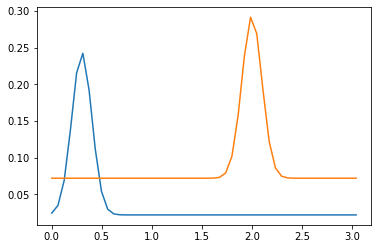

In [345]:
# helpers to construct some data
def Gauss(x,m,s): return np.asarray([normalize( 2*np.exp( -(x-m)**2 / (2*s**2) ) + 0.2 * np.ones_like(x) )]).transpose()

normalize = lambda a: a/np.sum(a)

def set_data():
    n,m = 50,50 # first and second density cardinality
    rmax_k,rmax_l = 8.,8.
    k,l = 30,30 # radial number for the first density
    r_radial = np.linspace(0.2,rmax_k,k) # discretization of the radial variable for the first
    s_radial = np.linspace(0.2,rmax_l,l) # discretization of the radial variable for the second
    dr_r = r_radial[1] - r_radial[0]
    dr_s = s_radial[1] - s_radial[0]
    xmax,ymax = np.pi - 0.1,np.pi - 0.1
    x,y = np.linspace(0,xmax,n),np.linspace(0.,ymax,m)
    a = 2 * Gauss(x,.3,.1)
    b = 2 * Gauss(y,2.,.1) + 0.05
    epsilon = 0.1
    return n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon
n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon = set_data()
plt.plot(x,a)
plt.plot(y,b)
plt.show()


In [202]:
# definition of the cost on the cone.
def Helpers_CVX(n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon):
    dr_r = r_radial[1] - r_radial[0]
    dr_s = s_radial[1] - s_radial[0]
    result = np.zeros((n ,m ))
    prod_a_b = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
                    result[i,j] = 2 * np.cos(min(np.sqrt(np.sum((x[i] - y[j])**2)),np.pi)) 
                    prod_a_b[i,j] = a[i,0] * b[j,0]
    temp_1 = np.zeros((k,l)) # square root products of discretization of radius.
    temp_2 = np.zeros((k,l)) # radial variable r
    temp_3 = np.zeros((k,l)) # radial variable s 

    for r in range(k):
        for s in range(l): 
            temp_1[r,s] = np.sqrt(r_radial[r] * s_radial[s])
            temp_2[r,s] = r_radial[r]
            temp_3[r,s] = s_radial[s]
    ones_n_m = np.ones((n,m))       
    temp = np.kron(temp_1,result)
    M = np.kron(temp_2,ones_n_m)
    N = np.kron(temp_3,ones_n_m)
    c = M + N - temp    
    weights = np.kron(temp_1**2 * dr_r * dr_s,prod_a_b) # weights are products of dr ds mu nu 
    log_weights = np.log(weights) 
    matrix = weights * np.exp(-c/epsilon)
    return c,weights,log_weights,temp_2,temp_3,matrix
    

def compute_proba_cvx(f,g,matrix,epsilon):
    f = np.exp(f)
    g = np.exp(g)
    temp = np.zeros((len(r_radial),len(f)))
    r_radial_temp = r_radial/epsilon
    for i in range(k):
        for j in range(n):
            temp[i,j] = f[j]**r_radial_temp[i]
    
    new_temp = temp.flatten()[:,np.newaxis] * matrix
    
    temp = np.zeros((len(s_radial),len(g)))
    s_radial_temp = s_radial/epsilon
    for i in range(len(s_radial)):
        for j in range(len(g)):
            temp[i,j] = g[j]**s_radial_temp[i]
    new_temp = new_temp * temp.flatten()[np.newaxis,:]
    return new_temp/np.sum(new_temp)

In [199]:
def Solver_CVXPY(n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon=1):
    c,weights,log_weights,temp_2,temp_3,matrix = Helpers_CVX(n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon)
    f_c1 = cp.Variable((n,1))
    g_c1 = cp.Variable((m,1))
    f_c_m = cp.kron(temp_2,f_c1@np.ones((1,m)))
    g_c_n = cp.kron(temp_3,np.ones((n,1))@g_c1.T)
    f_oplus_g_r_s = f_c_m + g_c_n - c + epsilon * log_weights
    cost =  cp.sum(a.T@f_c1 + b.T@g_c1) - epsilon * cp.log_sum_exp(f_oplus_g_r_s/epsilon)
    prob = cp.Problem(cp.Maximize((cost)))
    prob.solve(solver=cp.ECOS_BB,verbose = False)
    print("status:", prob.status)
    return f_c1.value[:,0],g_c1.value[:,0],matrix,c

In [200]:
n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon = set_data()
f_cvx,g_cvx,matrix,c = Solver_CVXPY(n,m,k,l,x,y,a,b,r_radial,s_radial)
probas_cvx = compute_proba_cvx(f_cvx,g_cvx,matrix,epsilon)

status: optimal


## We now implement a Sinkhorn type approach.

In [127]:
def Helpers(n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon):
    dr_r = r_radial[1] - r_radial[0]
    dr_s = s_radial[1] - s_radial[0]
    result = np.zeros((n ,m ))
    prod_a_b = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
                    result[i,j] = 2 * np.cos(min(np.sqrt(np.sum((x[i] - y[j])**2)),np.pi)) 
                    prod_a_b[i,j] = a[i,0] * b[j,0]
    temp_1 = np.zeros((k,l))
    temp_2 = np.zeros((k,l))
    temp_3 = np.zeros((k,l))
    for r in range(k):
        for s in range(l): 
            temp_1[r,s] = np.sqrt(r_radial[r] * s_radial[s])
            temp_2[r,s] = r_radial[r]
            temp_3[r,s] = s_radial[s]
    ones_n_m = np.ones((n,m))       
    temp = np.kron(temp_1,result)
    M = np.kron(temp_2,ones_n_m)
    N = np.kron(temp_3,ones_n_m)
    c = M + N - temp
    weights = np.kron(temp_1**2 * dr_r * dr_s,prod_a_b)
    log_weights = np.log(weights)
    matrix = weights * np.exp(-c/epsilon)
    return c,weights,log_weights,temp_2,temp_3,matrix

def compute_total_mass_coeff_sinkhorn(f,g,matrix,epsilon):
    temp = np.zeros((len(r_radial),len(f)))
    r_radial_temp = r_radial/epsilon
    for i in range(k):
        for j in range(n):
            temp[i,j] = f[j]**r_radial_temp[i]
            
    new_temp = temp.flatten()[:,np.newaxis] * matrix
    
    temp = np.zeros((len(s_radial),len(g)))
    s_radial_temp = s_radial/epsilon
    for i in range(len(s_radial)):
        for j in range(len(g)):
            temp[i,j] = g[j]**s_radial_temp[i]
    new_temp = new_temp * temp.flatten()[np.newaxis,:]
    return new_temp

def compute_proba_sinkhorn(f,g,matrix,epsilon):
    temp = np.zeros((len(r_radial),len(f)))
    r_radial_temp = r_radial/epsilon
    for i in range(k):
        for j in range(n):
            temp[i,j] = f[j]**r_radial_temp[i]

    new_temp = temp.flatten()[:,np.newaxis] * matrix
    
    temp = np.zeros((len(s_radial),len(g)))
    s_radial_temp = s_radial/epsilon
    for i in range(len(s_radial)):
        for j in range(len(g)):
            temp[i,j] = g[j]**s_radial_temp[i]
    new_temp = new_temp * temp.flatten()[np.newaxis,:]
    return new_temp/np.sum(new_temp)

def compute_coefficients_g_fixed(n,m,k,l,g,s_radial,b,matrix,epsilon):
    temp = np.zeros((l,m))
    s_radial_temp = s_radial/epsilon
    for i in range(l):
        for j in range(m):
            temp[i,j] = g[j]**s_radial_temp[i]
    
    new_temp = matrix * temp.flatten()[np.newaxis,:] # termwise multiply of different shapes
    return np.sum(new_temp,axis = -1)

def compute_coefficients_f_fixed(n,m,k,l,f,s_radial,b,matrix,epsilon):
    temp = np.zeros((k,n))
    r_radial_temp = r_radial/epsilon
    for i in range(k):
        for j in range(n):
            temp[i,j] = f[j]**r_radial_temp[i]

    new_temp = temp.flatten()[:,np.newaxis] * matrix # termwise multiply of different shapes
    return np.sum(new_temp,axis = 0)

def function_for_f(coefficients,r_radial,a,epsilon,total_mass = 1):
    def func_f(f):
        temp = np.zeros((len(r_radial),len(f)))
        r_radial_temp = r_radial
        for i in range(len(r_radial)):
            for j in range(len(f)):
                temp[i,j] = r_radial_temp[i] * (f[j]**(r_radial_temp[i]/epsilon))
        result = np.sum(temp* np.reshape(coefficients,(len(r_radial),len(f))),axis = 0) - total_mass * a.flatten()
        return result
    return func_f


def function_for_g(coefficients,s_radial,b,epsilon,total_mass = 1):
    def func_g(g):
        s_radial_temp = s_radial
        temp = np.zeros((len(s_radial),len(g)))
        for i in range(len(s_radial)):
            for j in range(len(g)):
                temp[i,j] = (s_radial_temp[i] ) * (g[j]**(s_radial_temp[i]/epsilon))                
        result =  np.sum(temp* np.reshape(coefficients,(len(s_radial),len(g))),axis = 0) - total_mass * b.flatten()
        return result
    return func_g

In [128]:
from scipy.optimize import root
def Sinkhorn_iterations(n,m,k,l,s_radial,r_radial,a,b,epsilon,iterations = 10): 
    c,weights,log_weights,temp_2,temp_3,matrix = Helpers(n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon)
    g = np.ones(m)
    f = np.ones(n)
    for i in range(iterations):
        coefficients_for_g = compute_coefficients_f_fixed(n,m,k,l,f,s_radial,b,matrix,epsilon)
        tot = np.sum(compute_total_mass_coeff_sinkhorn(f,g,matrix,epsilon))
        func_g = function_for_g(coefficients_for_g,s_radial,b,epsilon,total_mass = tot)
        new_g = root(func_g,g)
        g = new_g.x
        
        coefficients_for_f = compute_coefficients_g_fixed(n,m,k,l,g,s_radial,b,matrix,epsilon)
        tot = np.sum(compute_total_mass_coeff_sinkhorn(f,g,matrix,epsilon))
        func_f = function_for_f(coefficients_for_f,r_radial,a,epsilon,total_mass = tot)
        new_f = root(func_f,f)
        f = new_f.x
    return f,g,matrix,c

In [129]:
n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon = set_data()
f,g,weights,c = Sinkhorn_iterations(n,m,k,l,s_radial,r_radial,a,b,1.,iterations = 100)

### Sanity check: the convex optimization cvxpy and the sinkhorn iterations based on the root finding give the same solutions.

In [130]:
### Sanity check the two optimization lead to the same value.
print(np.sum(np.abs(np.exp(f_cvx) - f)),np.sum(np.abs(np.exp(g_cvx)-g)))

3.352081651697425e-07 9.660724811233479e-07


# We now implement the IPFP solution.

In [131]:
def Helpers_IPFP(n,m,k,l,x,y,a,b,r_radial,s_radial):
    dr_r = r_radial[1] - r_radial[0]
    dr_s = s_radial[1] - s_radial[0]
    result = np.zeros((n ,m ))
    prod_a_b = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
                    result[i,j] = 2 * np.cos(min(np.sqrt(np.sum((x[i] - y[j])**2)),np.pi)) 
                    prod_a_b[i,j] = a[i,0] * b[j,0]
    temp_1 = np.zeros((k,l))
    temp_2 = np.zeros((k,l))
    temp_3 = np.zeros((k,l))
    for r in range(k):
        for s in range(l): 
            temp_1[r,s] = np.sqrt(r_radial[r] * s_radial[s])
            temp_2[r,s] = r_radial[r]
            temp_3[r,s] = s_radial[s]
    ones_n_m = np.ones((n,m))       
    temp = np.kron(temp_1,result)
    M = np.kron(temp_2,ones_n_m)
    N = np.kron(temp_3,ones_n_m)
    c = M + N - temp
    weights = np.kron(temp_1**2 * dr_r * dr_s,prod_a_b)
    log_weights = np.log(weights)
    probas = np.exp(-c/epsilon) * weights
    
    return probas,c,weights,log_weights,temp_2,temp_3

def compute_updates_for_n(n,m,k,l,a,b,r_radial,s_radial,probas):
    renormalization_factor = 1./np.max(r_radial)
    temp = np.zeros((k,n))
    marginal_k_n = np.sum(probas,axis = 1)
    
    r_radial_temp = r_radial * renormalization_factor
    for i in range(k):
        for j in range(n):
            temp[i,j] = r_radial_temp[i]
    result =  np.sum(temp * np.reshape(marginal_k_n,(k,n)),axis = 0)
    #print("result for n ",result)
    return (a[:,0]*renormalization_factor)/result
            
def compute_updates_for_m(n,m,k,l,a,b,r_radial,s_radial,probas):
    renormalization_factor = 1./np.max(s_radial)
    temp = np.zeros((l,m))
    marginal_l_m = np.sum(probas,axis = 0)
    s_radial_temp = s_radial * renormalization_factor
    for i in range(l):
        for j in range(m):
            temp[i,j] = s_radial_temp[i]
    result =  np.sum(temp * np.reshape(marginal_l_m,(l,m)),axis = 0)
    return (b[:,0]*renormalization_factor)/result

def compute_probas_with_n_results(n,m,k,l,a,b,r_radial,s_radial,probas,updates):
    renormalization_factor = 1./np.max(r_radial)
    temp = np.zeros((k,n))
    r_radial_temp = r_radial*renormalization_factor
    for i in range(k):
        for j in range(n):
            temp[i,j] = updates[j]**r_radial_temp[i]
    return temp.flatten()[:,np.newaxis] * probas


def compute_probas_with_m_results(n,m,k,l,a,b,r_radial,s_radial,probas,updates):
    renormalization_factor = 1./np.max(s_radial)
    temp = np.zeros((l,m))
    s_radial_temp = s_radial * renormalization_factor
    for i in range(l):
        for j in range(m):
            temp[i,j] = updates[j]**s_radial_temp[i]
    return temp.flatten()[np.newaxis,:] * probas


def compute_proba(f,g,weights,c):
    temp = np.zeros((len(r_radial),len(f)))
    r_radial_temp = r_radial
    for i in range(k):
        for j in range(n):
            temp[i,j] = f[j]**r_radial_temp[i]
    exp_c = np.exp(-c/epsilon)
    new_temp = weights * exp_c # termwise multiply of same shapes
    new_temp = temp.flatten()[:,np.newaxis] * new_temp
    
    temp = np.zeros((len(s_radial),len(g)))
    s_radial_temp = s_radial
    for i in range(len(s_radial)):
        for j in range(len(g)):
            temp[i,j] = g[j]**s_radial_temp[i]
    new_temp = new_temp * temp.flatten()[np.newaxis,:]
    return new_temp

In [132]:
def IPFP_iterations(n,m,k,l,s_radial,r_radial,weights,a,b,iterations = 10): 
    probas,c,weights,log_weights,temp_2,temp_3 = Helpers_IPFP(n,m,k,l,x,y,a,b,r_radial,s_radial)
    for i in range(iterations):
        updates = compute_updates_for_n(n,m,k,l,a,b,r_radial,s_radial,probas)
        probas =  compute_probas_with_n_results(n,m,k,l,a,b,r_radial,s_radial,probas,updates)
        
        updates = compute_updates_for_m(n,m,k,l,a,b,r_radial,s_radial,probas)
        probas = compute_probas_with_m_results(n,m,k,l,a,b,r_radial,s_radial,probas,updates)
        
        probas /= np.sum(probas)
        
    return probas

def solve_IPFP(n,m,k,l,x,y,a,b,r_radial,s_radial,iterations = 10):
    probs,c,weights,log_weights,temp_2,temp_3 = Helpers_IPFP(n,m,k,l,x,y,a,b,r_radial,s_radial)
    probas = IPFP_iterations(n,m,k,l,s_radial,r_radial,weights,a,b,iterations = iterations)
    return probas    

In [133]:
n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon = set_data()
probas = IPFP_iterations(n,m,k,l,s_radial,r_radial,weights,a,b,iterations = 500)

### Sanity check: the solutions are the same. Note that the solution computed by the GIS algorithm is the optimal plan.

In [134]:
print("L1 differences between cvxpy and IPFP: ",np.sum(np.abs(probas_cvx/np.sum(probas_cvx) - probas)))

L1 differences between cvxpy and IPFP:  2.1961309366246197e-08


## Hereafter we compare the running time of our 3 implementations: GIS, Sinkhorn, CVX.
### We mention that this test is not a fair comparison between the 3 algorithms since our implementation is very very far from being optimized. 

In [135]:
n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon = set_data()
from timeit import default_timer as timer
start = timer()
probas_IPFP = solve_IPFP(n,m,k,l,x,y,a,b,r_radial,s_radial,iterations = 1000)
end = timer()
print("######################: GIS")
print("elapsed time GIS: ",end - start)
print("proba should sum up to 1 ",np.sum(probas_IPFP))

start = timer()
f_sink,g_sink,matrix,c = Sinkhorn_iterations(n,m,k,l,s_radial,r_radial,a,b,epsilon,iterations = 1000)
end = timer()
print("######################: Sinkhorn")
print("elpased time Sinkhorn: ",end - start)
probas_sinkhorn = compute_proba_sinkhorn(f_sink,g_sink,matrix,epsilon)

print("L1 differences between sinkhorn and GIS: ",np.sum(np.abs(probas_sinkhorn - probas_IPFP)))

start = timer()
f_cvx,g_cvx,matrix,c = Solver_CVXPY(n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon)
end = timer()
print("######################: CVX")
print("elpased time CVX: ",end - start)
probas_cvx = compute_proba_cvx(f_cvx,g_cvx,matrix,epsilon)
probas_cvx/=np.sum(probas_cvx)
print(np.sum(probas_cvx))
print("L1 differences between CVXPY and IPFP: ",np.sum(np.abs(probas_cvx - probas_sinkhorn)))

######################: GIS
elapsed time GIS:  0.389428845999646
proba should sum up to 1  1.0
######################: Sinkhorn
elpased time Sinkhorn:  4.764437202000408
L1 differences between sinkhorn and GIS:  2.4600219597824627e-15
status: optimal
######################: CVX
elpased time CVX:  2.109809462999692
1.0
L1 differences between CVXPY and IPFP:  2.1961309577154383e-08


## We now explore how the objective value evolves according to the discretization of the radial direction.

In [138]:
def Helpers(n,m,k,l,x,y,a,b,r_radial,s_radial):
    dr_r = r_radial[1] - r_radial[0]
    dr_s = s_radial[1] - s_radial[0]
    result = np.zeros((n ,m ))
    prod_a_b = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
                    result[i,j] = 2 * np.cos(min(np.sqrt(np.sum((x[i] - y[j])**2)),np.pi)) 
                    prod_a_b[i,j] = a[i,0] * b[j,0]
    temp_1 = np.zeros((k,l)) # square root products of discretization of radius.
    temp_2 = np.zeros((k,l)) # radial variable r
    temp_3 = np.zeros((k,l)) # radial variable s 

    for r in range(k):
        for s in range(l): 
            temp_1[r,s] = np.sqrt(r_radial[r] * s_radial[s])
            temp_2[r,s] = r_radial[r]
            temp_3[r,s] = s_radial[s]
    ones_n_m = np.ones((n,m))       
    temp = np.kron(temp_1,result)
    M = np.kron(temp_2,ones_n_m)
    N = np.kron(temp_3,ones_n_m)
    c = M + N - temp    
    weights = np.kron(temp_1**2 * dr_r * dr_s,prod_a_b) # weights are products of dr ds mu nu 
    log_weights = np.log(weights)
    return c,weights,log_weights,temp_2,temp_3

def construct_cost(n,m,temp_2,temp_3,c,weights):
    epsilon = 1.0
    f_c = cp.Variable((n,1))
    g_c = cp.Variable((m,1))
    f_c_m = cp.kron(temp_2,f_c@np.ones((1,m)))
    g_c_n = cp.kron(temp_3,np.ones((n,1))@g_c.T)
    f_oplus_g_r_s = f_c_m + g_c_n - c
    cost =  cp.sum(a.T@f_c + b.T@g_c) - epsilon * cp.sum(cp.multiply(cp.exp(f_oplus_g_r_s/epsilon),weights))
    return cost

## We fix the maximum radius and we vary the resolution of discretization of the radial variable.

In [140]:
# changing discretization parameters:
rmax = 14.
matrix_values = np.zeros((4,4))
liste_k = [20,40,50,60]
#liste_k = [20]
liste_l = [20,40,50,60]
#liste_l = [20]
for u in range(len(liste_k)):
    k = liste_k[u]
    for v in range(len(liste_l)):
        l = liste_l[v]
        r_radial = np.linspace(0.2,rmax,k) # discretization of the radial variable for the first
        s_radial = np.linspace(0.2,rmax,l) # discretization of the radial variable for the second
        dr_r = r_radial[1] - r_radial[0]
        dr_s = s_radial[1] - s_radial[0]
        c,weights,log_weights,temp_2,temp_3 = Helpers(n,m,k,l,x,y,a,b,r_radial,s_radial)
        cost = construct_cost(n,m,temp_2,temp_3,c,weights)
        prob = cp.Problem(cp.Maximize((cost)))
        prob.solve(solver=cp.ECOS_BB,verbose = False)
        print("status:"+ str(u) + " " + str(v) + " : ", prob.status)
        matrix_values[u,v] = prob.value

status:0 0 :  optimal
status:0 1 :  optimal
status:0 2 :  optimal
status:0 3 :  optimal
status:1 0 :  optimal
status:1 1 :  optimal
status:1 2 :  optimal
status:1 3 :  optimal
status:2 0 :  optimal
status:2 1 :  optimal
status:2 2 :  optimal
status:2 3 :  optimal
status:3 0 :  optimal
status:3 1 :  optimal
status:3 2 :  optimal
status:3 3 :  optimal


[[-6.47954189 -6.47447533 -6.47012307 -6.46664898]
 [-6.47137229 -6.46743759 -6.46335105 -6.46006398]
 [-6.46560581 -6.46190557 -6.45788814 -6.45465152]
 [-6.46104161 -6.45750246 -6.45353474 -6.45033466]]


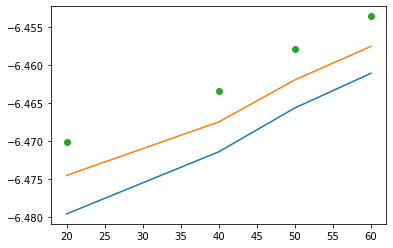

In [150]:
print(matrix_values)
plt.plot(liste_k,matrix_values[:,0])
plt.plot(liste_k,matrix_values[:,1])
plt.plot(liste_k,matrix_values[:,2],"o")
plt.show()

## The value does not vary too much which is a very mild sanity check. We now vary the maximum radius.

In [148]:
liste_r_max = [2,4,8,16,24,30]
#liste_r_max = [2,4]
k = 40 # radial number for the first density
l = 40 # radial number for the second density
results = []
for rmax in liste_r_max:
    r_radial = np.linspace(0.2,rmax,k) # discretization of the radial variable for the first
    s_radial = np.linspace(0.2,rmax,l) # discretization of the radial variable for the second
    dr_r = r_radial[1] - r_radial[0]
    dr_s = s_radial[1] - s_radial[0]
    c,weights,log_weights,temp_2,temp_3 = Helpers(n,m,k,l,x,y,a,b,r_radial,s_radial)
    cost = construct_cost(n,m,temp_2,temp_3,c,weights)
    prob = cp.Problem(cp.Maximize((cost)))
    if rmax == 30:
        verb = True
    else:
        verb = False
    prob.solve(solver=cp.ECOS,verbose = verb)
    print("status:"+ str(rmax) + " : ", prob.status)
    results.append(prob.value)


status:2 :  optimal
status:4 :  optimal
status:8 :  optimal
status:16 :  optimal
status:24 :  optimal
                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Jan 29 09:32:53 PM: Your problem has 23 variables, 0 constraints, and 0 parameters.
(CVXPY) Jan 29 09:32:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 29 09:32:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 29 09:32:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 29 09:32:53 PM: Compiling problem (target solver=E

(CVXPY) Jan 29 09:33:20 PM: Optimal value: -6.477e+00
(CVXPY) Jan 29 09:33:20 PM: Compilation took 7.794e-01 seconds
(CVXPY) Jan 29 09:33:20 PM: Solver (including time spent in interface) took 2.693e+01 seconds
status:30 :  optimal


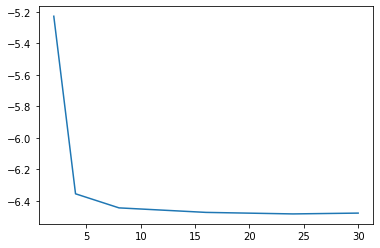

0.005174462638546373


In [149]:
plt.plot(liste_r_max,results)
plt.show()
print(results[-1] - results[-2])

## We now illustrate the computed quantities.

In [360]:
n,m,k,l,x,y,a,b,r_radial,s_radial,epsilon = set_data()
epsilon = 0.02
probas = IPFP_iterations(n,m,k,l,s_radial,r_radial,weights,a,b,iterations = 2000)

In [361]:
marginal_x = np.sum(probas,axis = 1)
marginal_y = np.sum(probas,axis = 0)
conic_x = np.reshape(marginal_x,(k,n))
conic_y = np.reshape(marginal_y,(l,m))
# Check that the integration wrt mass variable (first moment) gives the correct marginal
print(np.sum((np.sum(np.outer(r_radial,np.ones(n)) * conic_x,axis = 0) - a.transpose())**2))

8.596434901223812e-07


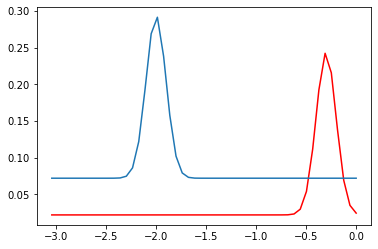

In [362]:
import matplotlib.pyplot as plt
plt.plot(-x,a,"r")
plt.plot(-y,b)
plt.show()

(1500,)


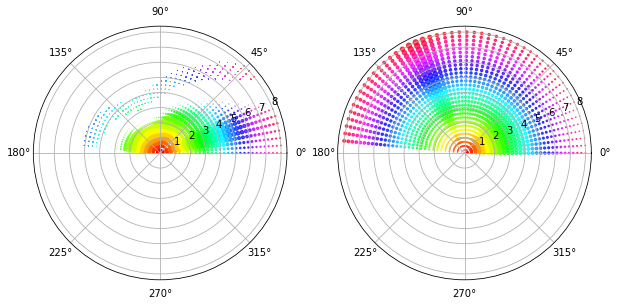

In [363]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
ax1 = plt.subplot(121,projection = "polar")
ax2 = plt.subplot(122, projection='polar')

coords_r1 = np.kron(r_radial,np.ones(n))
coords_theta1 = np.kron(np.ones(k),x)
print(np.shape(coords_r1))
ax1.scatter(coords_theta1, coords_r1, c=coords_r1, s=9500 * conic_x, cmap='hsv', alpha=0.75)

coords_r = np.kron(s_radial,np.ones(m))
coords_theta = np.kron(np.ones(l),y)

ax2.scatter(coords_theta, coords_r, c=coords_r, s=9500 * conic_y, cmap='hsv', alpha=0.75)

(30, 50) (30, 50)


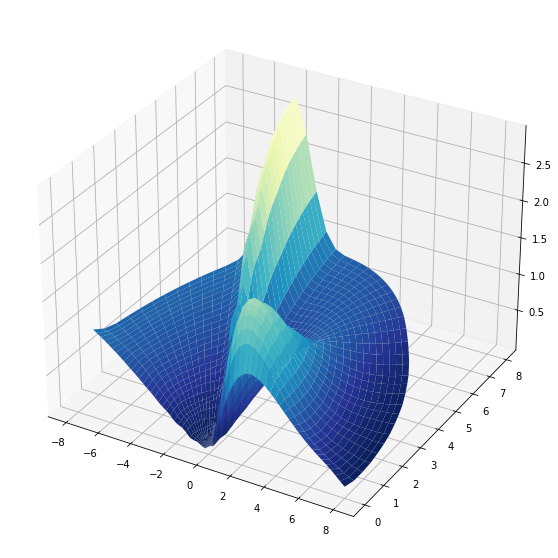

In [364]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
# Create the mesh in polar coordinates
R = np.outer(s_radial,np.ones(m))
P = np.outer(np.ones(l),y)

# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)
print(np.shape(X),np.shape(conic_y))

# Plot the surface.
ax.plot_surface(X, Y, 1000*conic_y, cmap=plt.cm.YlGnBu_r)
plt.show()

(30, 50) (30, 50)


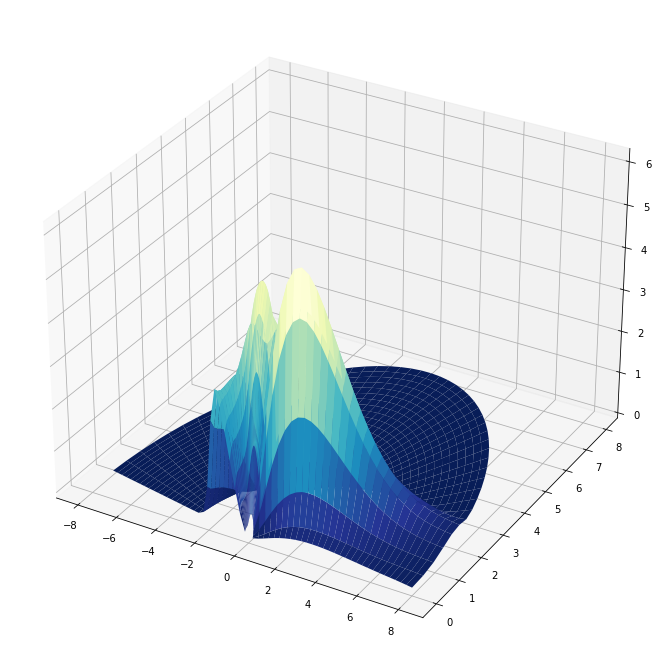

In [365]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')
# Create the mesh in polar coordinates
R = np.outer(r_radial,np.ones(n))
P = np.outer(np.ones(k),x)

# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)
print(np.shape(X),np.shape(conic_y))

# Plot the surface.
ax.plot_surface(X, Y, 1000*conic_x, cmap=plt.cm.YlGnBu_r)
plt.show()